### INFO284 Machine Learning Exam, spring 2024

#### Importing and versioncontrol for relevant libraries

In [266]:
import sys
print("Python version: {}".format(sys.version))
import pandas as pd
print("pandas version: {}".format(pd.__version__))
import matplotlib
print("matplotlib version: {}".format(matplotlib.__version__))
import numpy as np
print("NumPy version: {}".format(np.__version__))
import scipy as sp
print("SciPy version: {}".format(sp.__version__))
import IPython
print("IPython version: {}".format(IPython.__version__))
import sklearn
print("scikit-learn version: {}".format(sklearn.__version__))

Python version: 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]
pandas version: 2.1.1
matplotlib version: 3.7.2
NumPy version: 1.25.2
SciPy version: 1.11.2
IPython version: 8.12.0
scikit-learn version: 1.3.1


In [267]:
import pandas as pd
filePath = 'elektronisk-rapportering-ers-2018-fangstmelding-dca-simple.csv'
#keep in mind that the file is encoded in UTF-8, so it will only work if you have the correct version of pandas.
df = pd.read_csv(filePath, encoding="UTF-8" , delimiter=";")
df.head()

,Melding ID,Meldingstidspunkt,Meldingsdato,Meldingsklokkeslett,Starttidspunkt,Startdato,Startklokkeslett,Startposisjon bredde,Startposisjon lengde,Hovedområde start (kode),...,Art - FDIR,Art - gruppe (kode),Art - gruppe,Rundvekt,Lengdegruppe (kode),Lengdegruppe,Bruttotonnasje 1969,Bruttotonnasje annen,Bredde,Fartøylengde
0,1497177,01.01.2018,01.01.2018,00:00,31.12.2017,31.12.2017,00:00,"-60,35","-46,133",NaN,...,Antarktisk krill,506.0,Antarktisk krill,706714.0,5.0,28 m og over,9432.0,NaN,"19,87","133,88"
1,1497178,01.01.2018,01.01.2018,00:00,30.12.2017 23:21,30.12.2017,23:21,"74,885","16,048",20.0,...,Hyse,202.0,Hyse,9594.0,5.0,28 m og over,1476.0,NaN,"12,6","56,8"
2,1497178,01.01.2018,01.01.2018,00:00,30.12.2017 23:21,30.12.2017,23:21,"74,885","16,048",20.0,...,Torsk,201.0,Torsk,8510.0,5.0,28 m og over,1476.0,NaN,"12,6","56,8"
3,1497178,01.01.2018,01.01.2018,00:00,30.12.2017 23:21,30.12.2017,23:21,"74,885","16,048",20.0,...,Blåkveite,301.0,Blåkveite,196.0,5.0,28 m og over,1476.0,NaN,"12,6","56,8"
4,1497178,01.01.2018,01.01.2018,00:00,30.12.2017 23:21,30.12.2017,23:21,"74,885","16,048",20.0,...,Sei,203.0,Sei,134.0,5.0,28 m og over,1476.0,NaN,"12,6","56,8"


In [268]:
# Using the same seed for testing purposes makes the results more comparable
seed = 32

In [269]:
# Excluding irrelevant columns

# Fangstår has only 2 unique values
df.drop(columns = ['Fangstår'], inplace= True)

# Lengdegruppe (kode), Lengdegruppe, Bruttotonnasje 1969, Bruttotonnasje annen, Bredde, Fartøylengde all seem to be speaking of the boat doing the catching, with few unique values in each column.
# One of them should be kept as a feature, the rest discarded. We would suggest the most relevant to be Bruttotonasje, which speaks to how much cargo space there is.
# "Bruttotonnasje 1969" and "Bruttotonnasje annen" seem to have nan where the other one has a value, so first we will collapse them into one.
df['Bruttotonnasje'] = df['Bruttotonnasje annen'].combine_first(df['Bruttotonnasje 1969'])
df.drop(columns=['Bruttotonnasje annen', "Bruttotonnasje 1969","Lengdegruppe (kode)", "Lengdegruppe", "Bredde", "Fartøylengde"], inplace=True)

# All columns (kode) in them are cateogrical code representations of another column. For human-readability and to avoid mistaking the code for a continuous value we will remove them.
df.drop(columns=["Hovedområde start (kode)", "Lokasjon start (kode)", "Hovedområde stopp (kode)", "Lokasjon stopp (kode)", "Redskap FAO (kode)", "Redskap FDIR (kode)", "Hovedart FAO (kode)", "Hovedart - FDIR (kode)", "Art FAO (kode)", "Art - FDIR (kode)", "Art - gruppe (kode)", ], inplace = True)

# In both the "Redskap" and "Art" columns you have FAO and FDIR abbriviations. FAO = Food and Agriculture Organization of the United Nations and FDIR = Fiskeridirektoratet
# Due to "Hovedart" only having FAO uncoded we will stick to FAO. For the same reason we will remove "Art - gruppe"
df.drop(columns=["Art - gruppe", "Art - FDIR", "Redskap FDIR"], inplace=True)

# While time of day and date might be relevant we don't need all of them and we don't need to know when it was reported in. For now we will leave start/end date and time.
df.drop(columns=["Meldingstidspunkt", "Meldingsdato", "Meldingsklokkeslett", "Starttidspunkt", "Stopptidspunkt"], inplace=True)

# The areas where they start and stop have 6 columns. A pair of coordiantes and name of area x2. Since we prefer the continuous features and coordinates=name of place we are removing the name.
df.drop(columns=["Hovedområde start", "Hovedområde stopp"], inplace=True)

In [270]:
# After having checked to see what % of each column had nan values we decided just to drop them as at worst they were around 1.6 %
df = df.dropna()

In [271]:
# Focusing down on the species we want to investigate
# More might be added later as categories or ranges
df = df[df['Art FAO'].isin(['Torsk', 'Sei', 'Hyse'])]

In [272]:
# Removing parts of columns

# From varighet we remove anyting above 400 as according to lecturer that is in the high range of how long you would be fishing in a session.
# So we will consider them outliers or multiple sessions reported as one and exclude them for now.

df = df[df['Varighet'] <= 400]

# Maybe remove some outliers from "Trekkavstand". Above 50000 the frequency gets 100 instances per 5000 length.
# Just doing it for now, unsure of necessity
df = df[df['Trekkavstand'] <= 50000]

#correlation matrix
#chi square matrix
#r2 value accuracy
#Mlp
#deep learning pytorch
#scaling the data
#decicion treees - distribution - scaled data = good

In [273]:
# Manipulating columns

# The coordinates are strings, here I'm changing them to int so they're easier to use.
# Later we might potentially change them in a different way.
df['Startposisjon bredde'] = df['Startposisjon bredde'].str.replace(',', '').astype(int)
df['Startposisjon lengde'] = df['Startposisjon lengde'].str.replace(',', '').astype(int)
df['Stopposisjon bredde'] = df['Stopposisjon bredde'].str.replace(',', '').astype(int)
df['Stopposisjon lengde'] = df['Stopposisjon lengde'].str.replace(',', '').astype(int)

# Date/time could potentially be changed to month/hour?
# df['Startmåned'] = df['Startdato'].astype(str).str[3:5]
# df['Starttime'] = df['Startklokkeslett'].astype(str).str[3:5]
# df['Stoppmåned'] = df['Stoppdato'].astype(str).str[3:5]
# df['Stopptime'] = df['Stoppklokkeslett'].astype(str).str[3:5]
# df.drop(columns=['Startdato', "Startklokkeslett", "Stoppdato", "Stoppklokkeslett"], inplace=True)

# Many of the sea depth notations are positiv, which doesn't make sense.
# But the amount of them in relation to number of entries means it can't be discounted as an error
# In the lecture on fisheries it was mentioned that a lot fo these are inputed manually
# And that most of these non-sensical sea depths are actually correct, just lacking a minus.
# Therefore we are simply flipping all the positive sea depth into negatives.
df['Havdybde start'] = -df['Havdybde start'].abs()
df['Havdybde stopp'] = -df['Havdybde stopp'].abs()

In [274]:
# Pivoting table

# Pivoting table so rows that are information about the same session are put together
df = df.pivot_table(index=['Melding ID', 'Startdato', 'Startklokkeslett', 'Startposisjon bredde', 'Startposisjon lengde', 'Havdybde start', 'Stoppdato', 'Stoppklokkeslett', 'Varighet', 'Stopposisjon bredde', 'Stopposisjon lengde', 'Havdybde stopp', 'Trekkavstand', 'Redskap FAO', 'Hovedart FAO','Bruttotonnasje'], columns='Art FAO', values='Rundvekt', aggfunc='sum').reset_index()

# This creates a lot of nan values which we fill with 0
df = df.fillna(0)

# We add another column to indicate which was the dominant catch during that session
# Might be removed or deemed redunadant later on as it has a 86% match to "Hovedfangst FAO"
df['Hovedfangst'] = df[['Hyse', 'Sei', 'Torsk']].idxmax(axis=1)

print(f"After pre-processing the dataset has {df.shape[1]} columns and {df.shape[0]} rows")
df.head()

After pre-processing the dataset has 20 columns and 51083 rows


Art FAO,Melding ID,Startdato,Startklokkeslett,Startposisjon bredde,Startposisjon lengde,Havdybde start,Stoppdato,Stoppklokkeslett,Varighet,Stopposisjon bredde,Stopposisjon lengde,Havdybde stopp,Trekkavstand,Redskap FAO,Hovedart FAO,Bruttotonnasje,Hyse,Sei,Torsk,Hovedfangst
0,1497178,30.12.2017,23:21,74885,16048,-335,31.12.2017,04:16,295,74914,15969,-334,3970.0,"Bunntrål, otter",Hyse,1476.0,9594.0,134.0,8510.0,Hyse
1,1497178,31.12.2017,05:48,7491,15868,-403,31.12.2017,10:15,267,74901,16248,-277,11096.0,"Bunntrål, otter",Hyse,1476.0,9118.0,67.0,6651.0,Hyse
2,1497178,31.12.2017,11:34,74883,16056,-346,31.12.2017,16:49,315,74924,15742,-496,10215.0,"Bunntrål, otter",Hyse,1476.0,12432.0,68.0,5097.0,Hyse
3,1497178,31.12.2017,17:44,74931,15785,-443,31.12.2017,21:47,243,74926,15894,-358,3214.0,"Bunntrål, otter",Torsk,1476.0,6758.0,0.0,7022.0,Torsk
4,1497229,01.01.2018,10:01,67828,12972,-71,01.01.2018,11:04,63,67827,12942,-56,1269.0,Snurrevad,Hyse,51.0,4.0,0.0,0.0,Hyse


In [275]:
#counting number of rows
# print("Number of rows: ", df.shape[0])
#realising that i havent dropped any rows since the number of rows are still the same
# df.dropna(inplace=True)
# print("New number of rows: ", df.shape[0])
#actually gonna drop all rows other than torsk, sei, hyse. Since we are only interested in these three species. The other are underrepresented and not relevant for our analysis.
# df = df[df['Art - gruppe'].isin(['Torsk', 'Sei', 'Hyse', 'Annen flatfisk, bunnfisk og dypvannsfisk'])]
# print("Only focusing on torsk sei hyse and Annen flatfisk, bunnfisk og dypvannsfisk: ", df.shape[0])
# df.head()
#so now we are working with %{df}.


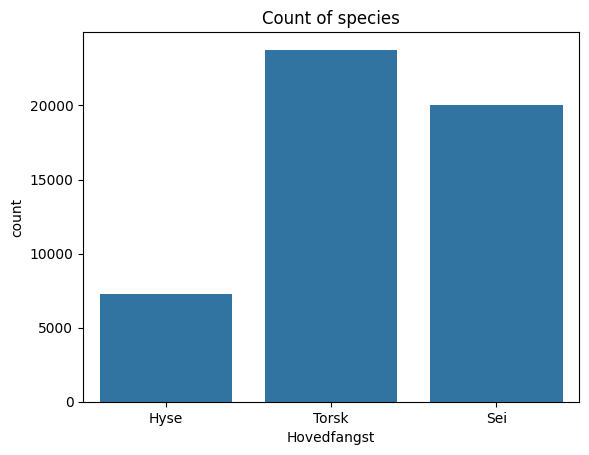

In [276]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
#presenting the count of the different species in the dataset with a barplot
sns.countplot(x='Hovedfangst', data=df)
plt.title('Count of species')
plt.show()

<Axes: xlabel='Havdybde start', ylabel='Havdybde stopp'>

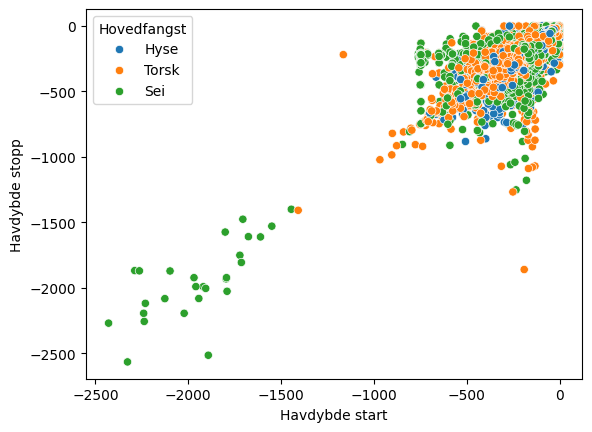

In [277]:
#plotting havdybde start and havdybde stopp using seaborn with different color for each species
sns.scatterplot(x='Havdybde start', y='Havdybde stopp', data=df, hue='Hovedfangst')
#viewing the plot and seeing it is so dense that it is hard to see the differences between the species. Additionally there are a lot of species over 0 which does not make sense when fishing.

#maybe we should use a threshold for the depth, since it is not possible to fish at 0 depth?
#then we will loose a lot of data points, so maybe there is a way to transform the outliers?
#But then again the transformed outliers will be useless since the initial values are not reliable? Are depth feature even reliable?
#note: Should probably transform the Art-gruppe to numerical values with one hot encoding.

#### Current thoughts:
How will we treat outliers and all above 0 depth?

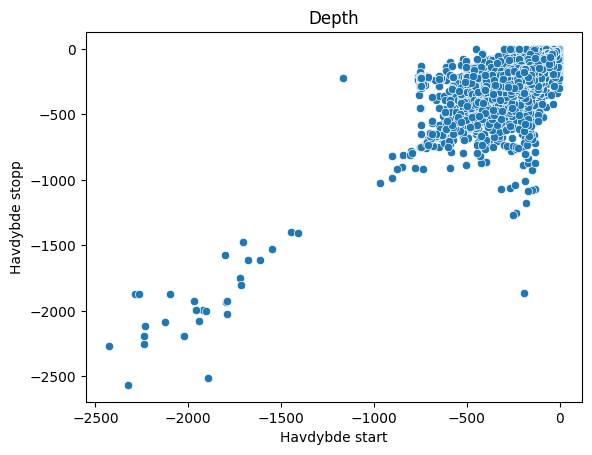

Art FAO,Melding ID,Startdato,Startklokkeslett,Startposisjon bredde,Startposisjon lengde,Havdybde start,Stoppdato,Stoppklokkeslett,Varighet,Stopposisjon bredde,...,Havdybde stopp,Trekkavstand,Redskap FAO,Hovedart FAO,Bruttotonnasje,Hyse,Sei,Torsk,Hovedfangst,Dominant Art
0,1497178,30.12.2017,23:21,74885,16048,-335,31.12.2017,04:16,295,74914,...,-334,3970.0,"Bunntrål, otter",Hyse,1476.0,9594.0,134.0,8510.0,Hyse,Hyse
1,1497178,31.12.2017,05:48,7491,15868,-403,31.12.2017,10:15,267,74901,...,-277,11096.0,"Bunntrål, otter",Hyse,1476.0,9118.0,67.0,6651.0,Hyse,Hyse
2,1497178,31.12.2017,11:34,74883,16056,-346,31.12.2017,16:49,315,74924,...,-496,10215.0,"Bunntrål, otter",Hyse,1476.0,12432.0,68.0,5097.0,Hyse,Hyse
3,1497178,31.12.2017,17:44,74931,15785,-443,31.12.2017,21:47,243,74926,...,-358,3214.0,"Bunntrål, otter",Torsk,1476.0,6758.0,0.0,7022.0,Torsk,Torsk
4,1497229,01.01.2018,10:01,67828,12972,-71,01.01.2018,11:04,63,67827,...,-56,1269.0,Snurrevad,Hyse,51.0,4.0,0.0,0.0,Hyse,Hyse


In [278]:
#plotting depth, it now works correctly with negated integers.
sns.scatterplot(x='Havdybde start', y='Havdybde stopp', data=df)
plt.title('Depth')
plt.show()

# Get the name of the category with the max value in the Dominant Art row
df['Dominant Art'] = df[['Hyse', 'Sei', 'Torsk']].idxmax(axis=1) # idmax will also return the first occurence of the max value
df.head()

#### Further exploring correlations in data

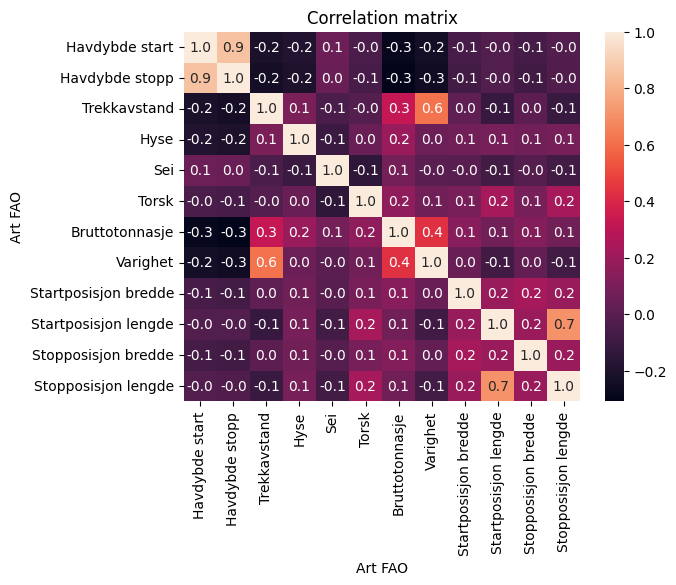

In [279]:
#trying correlation matrix
#defining a correlation matrix version of the dataframe with only the columns with numerical values
df_corr = df[['Havdybde start', 'Havdybde stopp', 'Trekkavstand', 'Hyse', 'Sei', 'Torsk', 'Bruttotonnasje', 'Varighet', 'Startposisjon bredde', 'Startposisjon lengde', 'Stopposisjon bredde', 'Stopposisjon lengde']]

#plotting the correlation matrix
sns.heatmap(df_corr.corr(), annot=True, fmt=".1f" ) 
plt.title('Correlation matrix')
plt.show()
#numerical values in the matrix are not showing well, need more space between them.
#adding space